In [1]:
from __future__ import division
import keras
import numpy as np
import pandas as pd
from utils import fx_1minute_bar_catalog, load_1minute_fx_bars, logreturn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


In [2]:
#filename = 'moving_average_500_500_500_500_20172901-194204.h5'
filename = 'saves/moving_average_500_500_500_500_20172901-221323.h5'
model = keras.models.load_model(filename)

In [4]:
#model.summary()

TODO: record, exact training history of this model.

was trained using:

http://localhost:8888/notebooks/fxdata-moving-average-signals.ipynb

In [5]:
catalog = fx_1minute_bar_catalog()
for k in catalog.keys():
    print k, sorted(catalog[k])

EURJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPCHF ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
USDJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAGUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


XAUGBP 2014 good
```
0 -24.006137497
1 -18.8588801909
2 2.8667225482
3 26.9078096808
4 22.8008012843
```
XAUUSD 2014
```
0 -29.8168921148
1 -22.4982650542
2 9.87497013618
3 10.3252027896
4 26.3714604262
```

XAUUSD 2015
```
0 -60.9791955775
1 -20.3033646518
2 -5.24774211161
3 22.307311691
4 29.0843892895
```

EURJPY 2015
```
0 -2.80814288973
1 -5.45890309854
2 -0.382935895543
3 1.27519156188
4 3.5130369436
```

GBPUSD 2015
```
0 -0.00624628916692
1 -0.0588986113089
2 0.0142498676861
3 0.0232730017919
4 0.00491347882038
```

In [3]:
ds = load_1minute_fx_bars('XAUUSD', 2016)[['close']]
#ds['close'] = 1/ds['close']

In [4]:
def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return np.tanh(15000 * (sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh(10000 * (sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

px = logreturn(ds['close'], ds['close'].shift(1)).cumsum()
ds['px'] = px
for period in [2,4,8,16,32,64,128,256]:
    ds['lret-{}'.format(period)] = np.tanh(logreturn(px, px.shift(period)))
    ds['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
    ds['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)


utils.py:109: RuntimeWarning: invalid value encountered in log
  return np.log(px_latest / px_prev)


In [5]:
price = ds['close']
ds = ds.drop('close',axis=1).fillna(0.0)

In [6]:
ds.shape

(353415, 25)

In [7]:
%%time
pred = model.predict(ds.as_matrix())

CPU times: user 1min 17s, sys: 4.74 s, total: 1min 22s
Wall time: 33.6 s


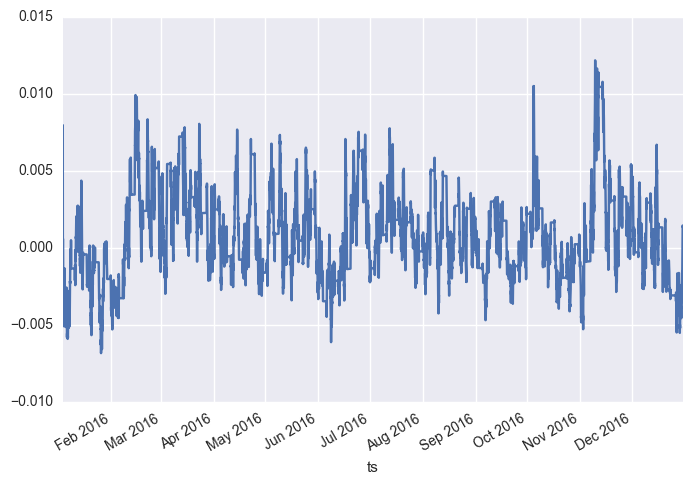

In [14]:
idx = ds.index
plt.figure()#figsize=(20,12))
#pp = pd.Series((-2*pred[:,0] + -1*pred[:,1] + 1*pred[:,3] + 2*pred[:,4]), index=idx)
pp = pd.Series((-1*pred[:,0]  + 1*pred[:,4]), index=idx)
pp.ewm(1000).mean().plot()

In [15]:
ANN_FACTOR = np.sqrt(260*24*60/10)

In [16]:
fut_return = ANN_FACTOR *(price.shift(-10)- price)/price
fut_return.mean()

0.00049286713707610938

sig 0.000608443920983
ewma: 1 0.000469731019552
ma: 1 0.000608443920983
ewma: 2 0.000221757479393
ma: 2 0.000510732906225
ewma: 3 3.56376072631e-05
ma: 3 0.000478422548057
ewma: 4 -0.000249462673751
ma: 4 0.000385410793112
ewma: 5 -0.000445698720579
ma: 5 0.00025850450725
ewma: 6 -0.000517594172061
ma: 6 0.000199360779624
ewma: 7 -0.000632755577612
ma: 7 -2.05859564703e-05
ewma: 8 -0.000557255681104
ma: 8 -0.000121652118844
ewma: 9 -0.000505091147917
ma: 9 -0.000278729197579


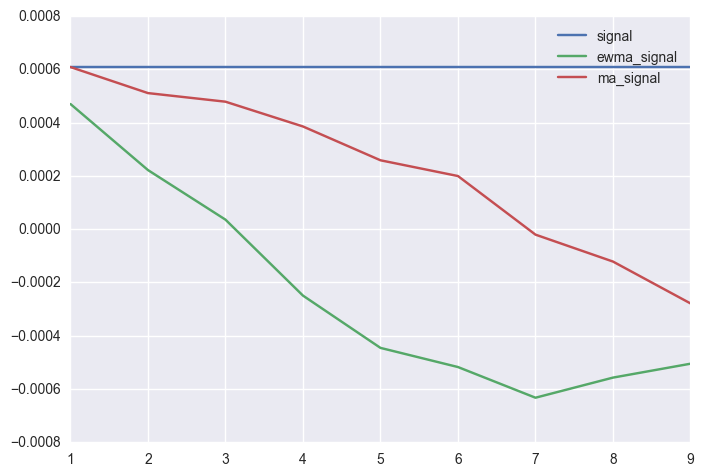

In [17]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).mean()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).mean()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).mean()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

In [18]:
fut_return.std()

0.16108250911419525

sig 0.161082114017
ewma: 1 0.161082578243
ma: 1 0.161082114017
ewma: 2 0.161083110489
ma: 2 0.161082453459
ewma: 3 0.16108325919
ma: 3 0.161082552663
ewma: 4 0.161083069965
ma: 4 0.161082802059
ewma: 5 0.161082646531
ma: 5 0.161083055709
ewma: 6 0.161082431558
ma: 6 0.161083139765
ewma: 7 0.161082020351
ma: 7 0.161083261817
ewma: 8 0.161082299234
ma: 8 0.161083217195
ewma: 9 0.161082471248
ma: 9 0.161083021983


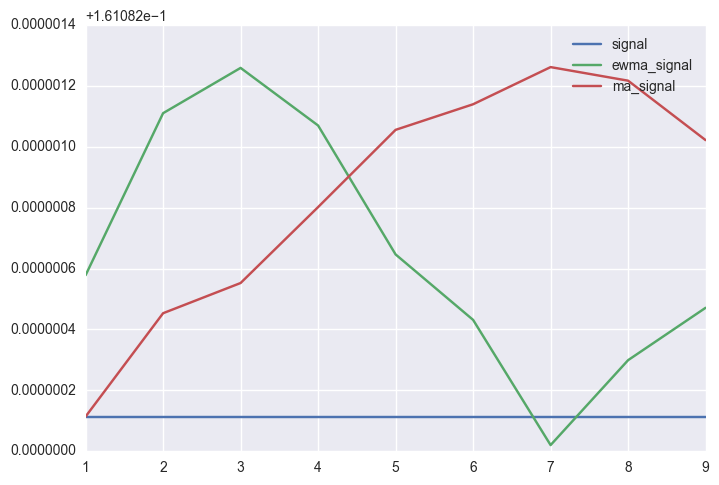

In [19]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).std()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).std()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).std()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

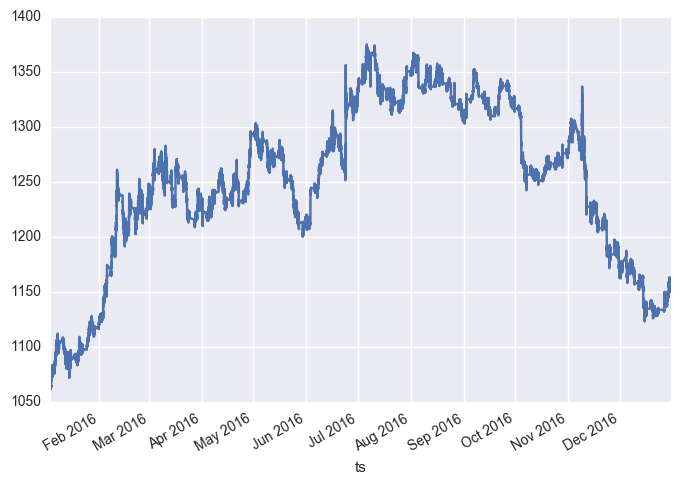

In [20]:
price.plot()

- expected return
- trading cost. frequency


In [21]:
print sx

[0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484, 0.16108211401696484]


----------------------

In [22]:
pred.max(axis=0)

array([ 0.41144004,  0.26192585,  0.59318876,  0.26478693,  0.43557826], dtype=float32)

In [23]:
np.argmax(pred, axis=1)

array([2, 2, 2, ..., 0, 4, 0])

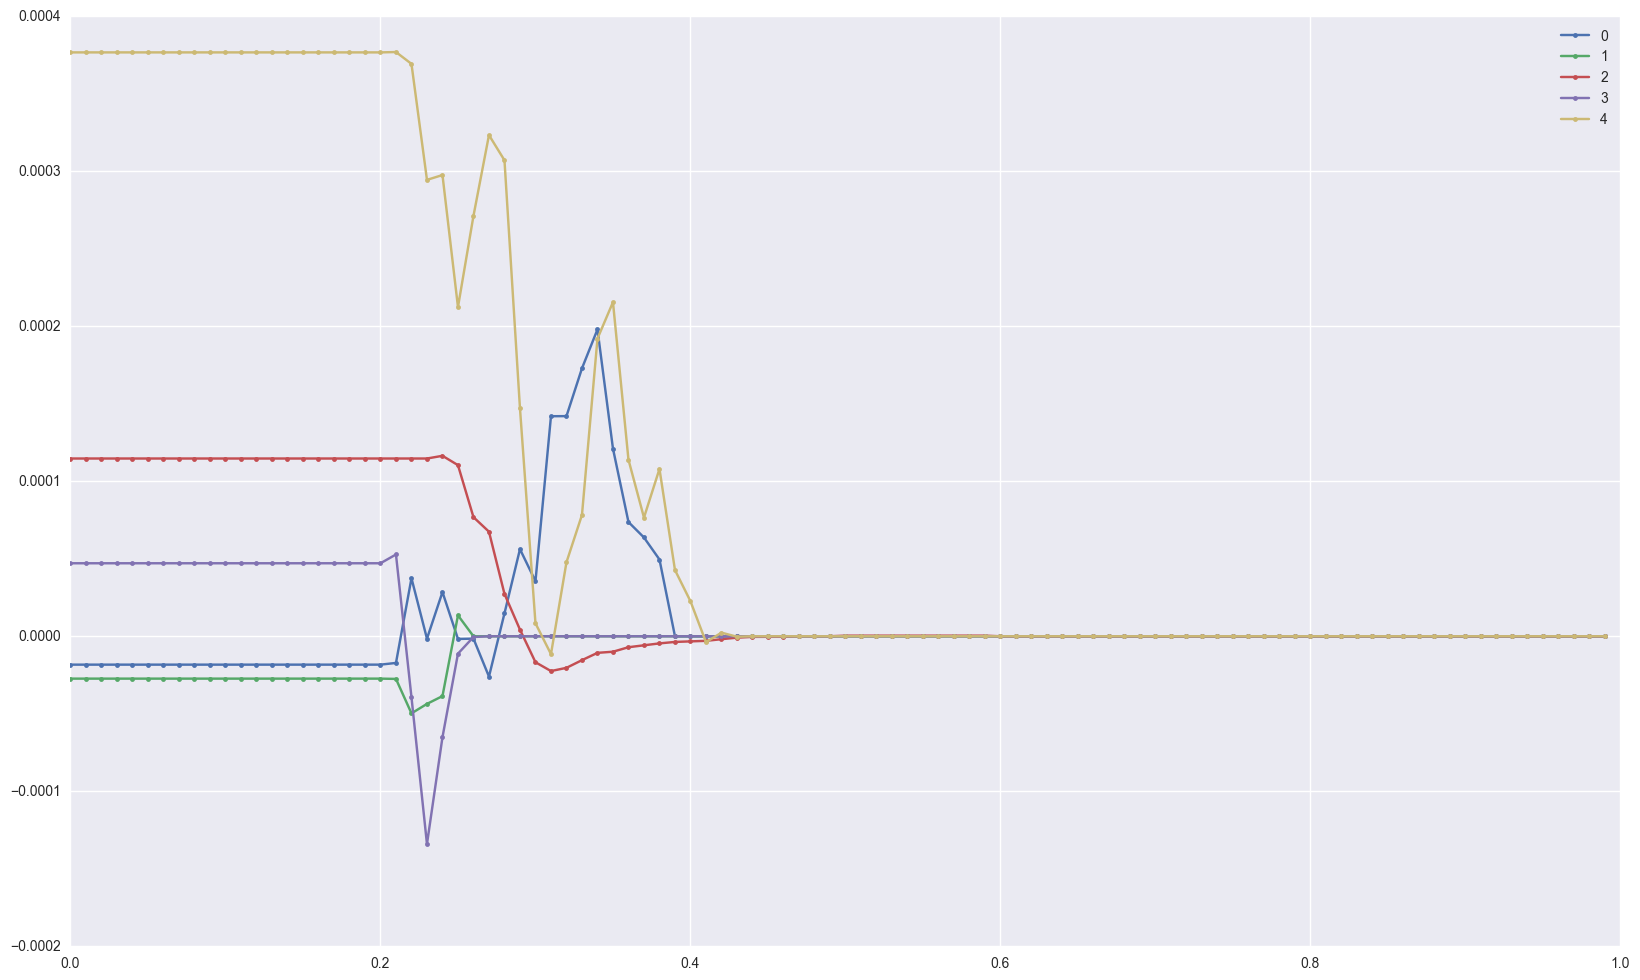

In [24]:
FIGSIZE = (20,12)
plt.figure(figsize=FIGSIZE)
STEPS = 100
for idx in range(5):
    fracs  = []
    results = []
    for i in range (STEPS):
        frac = i/STEPS
        result = ((np.argmax(pred, axis=1) == idx) * (pred[:,idx] > frac) * fut_return).mean()
        #result = ((np.argmax(pred, axis=1) == idx) *  fut_return).mean()
        fracs.append(frac)
        results.append(result)
    #print fracs, results
    plt.plot(fracs,results,'.-', label=str(idx))
plt.legend()
plt.show()
    

In [25]:
pred_categories = np.argmax(pred, axis=1)

In [26]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()

0 -0.183016548241
1 -0.273253801293
2 1.14686901932
3 0.471079127815
4 3.76699357316


In [27]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()
 

0 -0.183016548241
1 -0.273253801293
2 1.14686901932
3 0.471079127815
4 3.76699357316


In [33]:
y_true = pd.qcut(fut_return,5, labels=False)

In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, classification_report

In [42]:
true_classes = y_true.fillna(0.0).astype(int)

In [43]:
print classification_report(true_classes, pred_categories)

                     

             precision    recall  f1-score   support

          0       0.28      0.28      0.28     70691
          1       0.25      0.21      0.23     70681
          2       0.36      0.10      0.16     70681
          3       0.24      0.31      0.27     70681
          4       0.27      0.43      0.33     70681

avg / total       0.28      0.27      0.26    353415



In [41]:
print classification_report(y_true.fillna(0.0).astype(int), np.random.randint(5,  size=len(y_true)))

             precision    recall  f1-score   support

          0       0.20      0.20      0.20     70691
          1       0.20      0.20      0.20     70681
          2       0.20      0.20      0.20     70681
          3       0.20      0.20      0.20     70681
          4       0.20      0.20      0.20     70681

avg / total       0.20      0.20      0.20    353415



final balance 1019.44204402


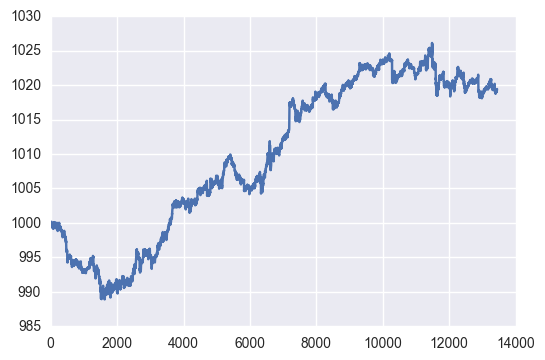

In [167]:
INITIAL = 1000.0
RISK = 0.10
balance = INITIAL
holdings = 0
holding_period=10
countdown = 0
BPS = 1e-4
cost = 0.1 * BPS
bals = []

idx = ds.index
for i in range(1,len(idx)-1):
    prediction = pp[i]
    #prediction = np.random.randn()
    prx = price[i+1]
    amt = balance * RISK / price[i]

    #print i, prediction,prx
    if countdown == 0 and holdings == 0:

        if prediction > 0:
            balance -= prx *(1+cost) * amt
            holdings += amt
            #print "bought",amt,"at",prx 
        else:
            balance += prx *(1-cost)* amt
            holdings -= amt
            #print "sold",amt,"for",prx 
        countdown = holding_period
    elif countdown == 0:
        # dispose of assets if prediction opposite to current holding
        if np.sign(prediction) != np.sign(holdings):
            balance += prx * holdings
            # print "disposed of ", holdings, "at", prx,". balance=", balance
            holdings = 0
            bals.append(balance)
    else:
        countdown -= 1

# dispose of any holdings, before reporting final balance:
if holdings !=0:
    balance += prx * holdings
    holdings = 0
    bals.append(balance)
    
print "final balance", balance
plt.plot(bals)

In [165]:
(bals[-1] - bals[0]) / np.array(bals).std()

1.7106095903280205